# 1. Importing neccessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import pathlib

# Import machine learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow import keras, expand_dims, newaxis
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPool2D
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical, plot_model

# Import image processing libraries
from PIL import Image

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Configure Matplotlib to display inline in Jupyter notebooks
%matplotlib inline

# 2. Loading the DATA

In [3]:
path='/content/drive/MyDrive/data_3/dataset'
dataset_path= os.listdir(path)
print (dataset_path)
print("Types of classes labels found: ", len(dataset_path))

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Types of classes labels found:  4


# 3. EDA

In [4]:
class_labels = []
for folder in dataset_path:
    folder_path = os.path.join(path, folder)
    folder_files = os.listdir(folder_path)
    for image in folder_files:
        image_path = os.path.join(folder_path, image)
        class_labels.append((folder, image_path))
print(class_labels[:2])

[('cataract', '/content/drive/MyDrive/data_3/dataset/cataract/1460_right.jpg'), ('cataract', '/content/drive/MyDrive/data_3/dataset/cataract/2101_left.jpg')]


In [5]:
df = pd.DataFrame(data=class_labels, columns=['Label', 'image'])
df.head()

,Label,image
0,cataract,/content/drive/MyDrive/data_3/dataset/cataract...
1,cataract,/content/drive/MyDrive/data_3/dataset/cataract...
2,cataract,/content/drive/MyDrive/data_3/dataset/cataract...
3,cataract,/content/drive/MyDrive/data_3/dataset/cataract...
4,cataract,/content/drive/MyDrive/data_3/dataset/cataract...


In [6]:
df.tail()

,Label,image
4261,normal,/content/drive/MyDrive/data_3/dataset/normal/2...
4262,normal,/content/drive/MyDrive/data_3/dataset/normal/2...
4263,normal,/content/drive/MyDrive/data_3/dataset/normal/2...
4264,normal,/content/drive/MyDrive/data_3/dataset/normal/2...
4265,normal,/content/drive/MyDrive/data_3/dataset/normal/2...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4266 entries, 0 to 4265
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4266 non-null   object
 1   image   4266 non-null   object
dtypes: object(2)
memory usage: 66.8+ KB


In [8]:
class_counts = df['Label'].value_counts()
print(class_counts)

Label
diabetic_retinopathy    1098
normal                  1094
cataract                1037
glaucoma                1037
Name: count, dtype: int64


👉 The dataset is fairly balanced with approximately equal counts of images for each category

## 3.1 Visualize the class distribution

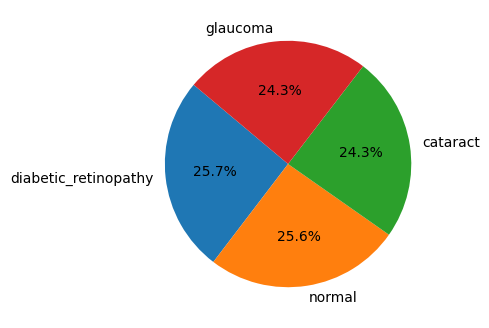

In [9]:
plt.figure(figsize=(12, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.show();

In [10]:
missing_values = df.isnull().sum()
print(missing_values)

Label    0
image    0
dtype: int64


👉 There is no missing value in the image dataset

##  3.2 Display Sample Images from Each Class

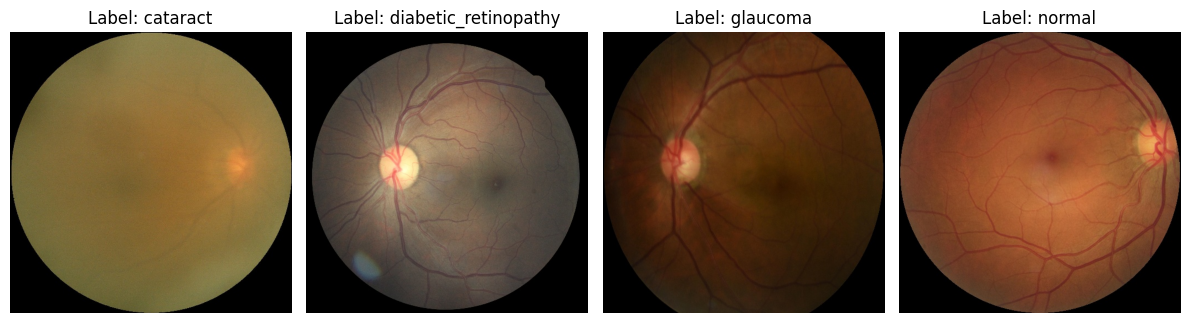

In [11]:
def display_sample_images(df, n=3):
    plt.figure(figsize=(12, 5))
    labels_seen = set()
    images_to_display = []

    for index, row in df.iterrows():
        label = row['Label']
        img_path = row['image']
        if label in labels_seen:
            continue
        images_to_display.append((label, img_path))
        labels_seen.add(label)
        if len(images_to_display) == 4:
            break

    for i, (label, img_path) in enumerate(images_to_display):
        img = mpimg.imread(img_path)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(df, n=4)

In [12]:
def calculate_image_size(image_path):
    try:
        img = Image.open(image_path)
        width, height = img.size
        return width, height
    except IOError:
        print(f"Failed to open image: {image_path}")
        return None

num_images_to_print = 3
for i in range(min(num_images_to_print, len(class_labels))):
    label, image_path = class_labels[i]
    size = calculate_image_size(image_path)
    if size:
        print(f"Image: {image_path} | Size: {size[0]}x{size[1]} pixels")

Image: /content/drive/MyDrive/data_3/dataset/cataract/1460_right.jpg | Size: 512x512 pixels
Image: /content/drive/MyDrive/data_3/dataset/cataract/2101_left.jpg | Size: 512x512 pixels
Image: /content/drive/MyDrive/data_3/dataset/cataract/2107_left.jpg | Size: 512x512 pixels


In [13]:
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
df.head()

,Label,image
0,0,/content/drive/MyDrive/data_3/dataset/cataract...
1,0,/content/drive/MyDrive/data_3/dataset/cataract...
2,0,/content/drive/MyDrive/data_3/dataset/cataract...
3,0,/content/drive/MyDrive/data_3/dataset/cataract...
4,0,/content/drive/MyDrive/data_3/dataset/cataract...


In [14]:
df.tail()

,Label,image
4261,3,/content/drive/MyDrive/data_3/dataset/normal/2...
4262,3,/content/drive/MyDrive/data_3/dataset/normal/2...
4263,3,/content/drive/MyDrive/data_3/dataset/normal/2...
4264,3,/content/drive/MyDrive/data_3/dataset/normal/2...
4265,3,/content/drive/MyDrive/data_3/dataset/normal/2...


In [15]:
class_counts = df['Label'].value_counts()
print(class_counts)

Label
1    1098
3    1094
0    1037
2    1037
Name: count, dtype: int64


## 3.3  Train-Test Split

In [16]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_val_df, test_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (2729, 2)
Validation shape: (683, 2)
Test shape: (854, 2)


In [17]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [18]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image'].values, train_df['Label'].values))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image'].values, val_df['Label'].values))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels)

(32, 256, 256, 3)
tf.Tensor([3 1 2 2 3 2 3 1 1 0 1 1 1 3 1 1 1 2 3 1 0 0 2 2 3 1 1 3 1 2 1 1], shape=(32,), dtype=int64)


#4. Model Building

In [19]:
model = Sequential([Input(shape=(256, 256, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])


loss, accuracy = model.evaluate(val_ds)
print(f'Validation accuracy: {accuracy}')

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - accuracy: 0.4799 - loss: 1.1732 - val_accuracy: 0.6237 - val_loss: 0.8475
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 526s 6s/step - accuracy: 0.7107 - loss: 0.6822 - val_accuracy: 0.6940 - val_loss: 0.6830
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step - accuracy: 0.7569 - loss: 0.5808 - val_accuracy: 0.7570 - val_loss: 0.5449
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 511s 6s/step - accuracy: 0.7825 - loss: 0.5284 - val_accuracy: 0.7716 - val_loss: 0.5222
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 560s 6s/step - accuracy: 0.7973 - loss: 0.4786 - val_accuracy: 0.7775 - val_loss: 0.5385
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 605s 6s/step - accuracy: 0.8133 - loss: 0.4555 - val_accuracy: 0.7965 - val_loss: 0.4867
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 504s 6s/step - accuracy: 0.8285 - loss: 0.4192 - val_accuracy: 0.7892 - val_loss: 0.4658
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - accuracy: 0.8459 - loss: 0.3944 - val_accuracy: 0.8155 - v

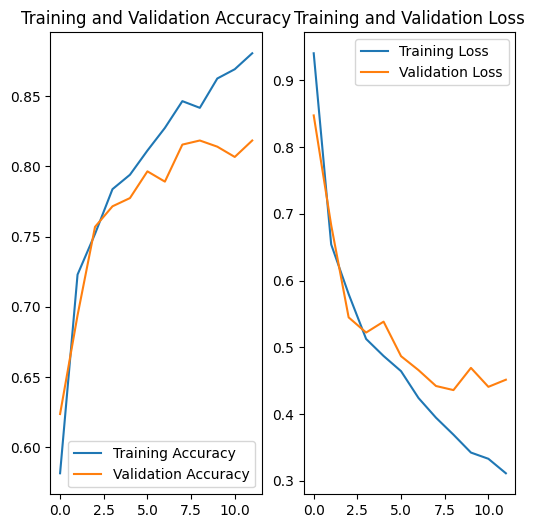

In [23]:
epochs=12
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(6,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4.3 Evaluate the Model on Test Data

In [24]:
test_data = tf.data.Dataset.from_tensor_slices((test_df['image'].values, test_df['Label'].values))
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
results = model.evaluate(test_data, verbose=1)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8411 - loss: 0.4215
Test Loss: 0.4619629383087158
Test Accuracy: 0.8149883151054382


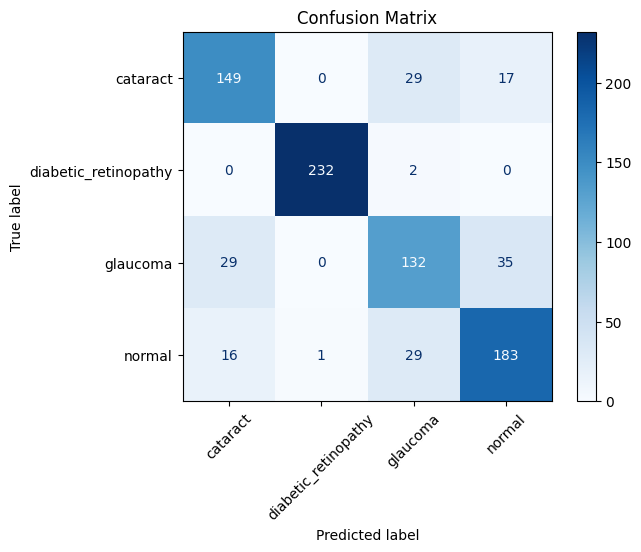

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_df['Label'].values
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.inverse_transform([0, 1, 2, 3]))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


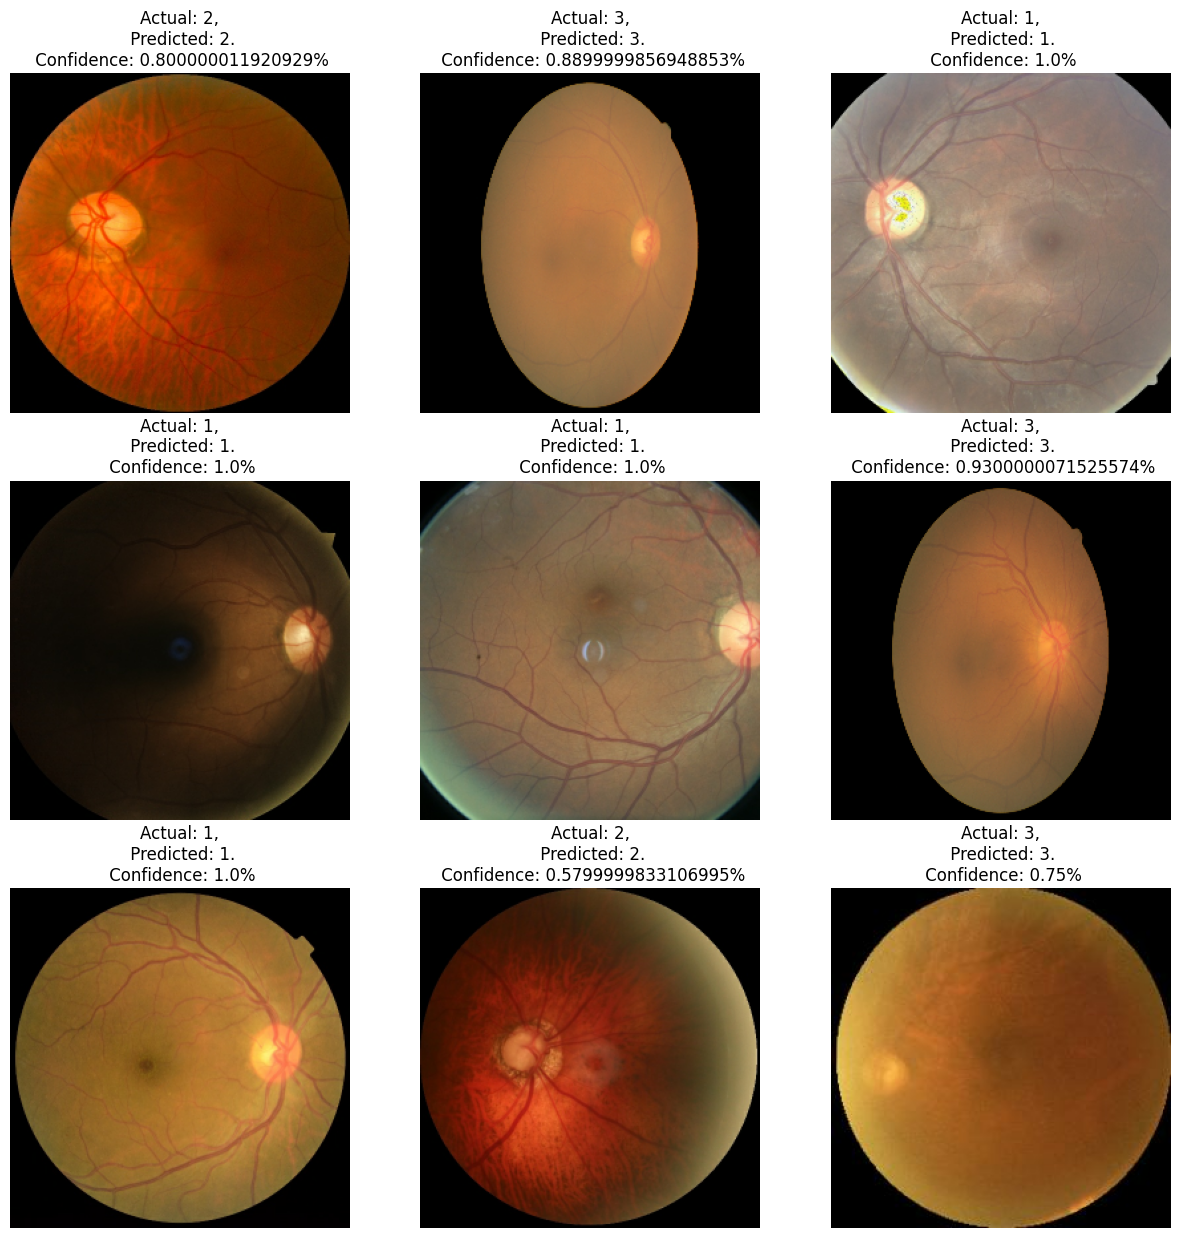

In [30]:
def predict(model, img):
    img_array = tf.expand_dims(img, 0)
    predictions = model.predict(img_array)
    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))

for images, lbs in val_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images[i].numpy()

        img = (img * 255).astype("uint8")

        plt.imshow(img)

        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [31]:
test_labels = []
predictions = []

for images, labels in test_data:
    test_labels.extend(labels.numpy())
    preds = model.predict(images)
    predictions.extend(tf.argmax(preds, axis=1).numpy())

conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(test_labels, predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print("Classification Report:")
print(class_report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
Confusion Matrix:
[[149  

In [33]:
model.save('my_model.keras')
